# Develop model
 Loads data for train and validation, performs hyperparameter search if necessary, trains model and save files to use for test and online scoring

 0. Load libraries
 1. Load data
 2. Hyperparameter search <br>
 3. Train model with predefined hyperparameters
 4. Save train model and buckets to score rest of transactions
 5. Evaluate model with Train/Validation dataset <br>
 6. Evaluate model with Test dataset
 

## Load libraries 
Install & load python libraries

In [1]:
pip install tabgan==1.3.3 #9500 secs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 19.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 4.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
  Attempting uninstall: dask
    Found existing installation: dask 2024.3.1
    Uninstalling dask-2024.3.1:
      Successfully uninstalled dask-2024.3.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.3.1
    Uninstalling distributed-2024.3.1:
      Successfully uninstalled distributed-2024.3.1
  Attempting uninstall: dask-expr
    Found existing installation: dask-expr 1.0.5
    Uninstalling dask-expr-1.0.5:
      Successfully uninstalled dask-expr-1.0.5
ERROR: pi

In [4]:
## required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>
Define is do hyperparameter search or not

In [6]:
hp_search = 0 #whether search hyperparameters or run directly 
save_model = 1 # if created model wil be saved

s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodosRetrain/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodosRetrain/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [7]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [8]:
#List of columns from dataframe
def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'branch_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'sender_state', 'branch_has_fraud', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'receiver_transaction_count', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick', '01_isBankDep', 'sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365', 'sender_days_to_last_transa

In [9]:
#Variables to use in model
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud',
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','01_sender_sending_days',
    'branch_working_days', '01_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', '01_hour_receiver']

In [10]:
#Load train & validation and join both for latter split
X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [11]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.0025670808616864993

## Hyperparameter search

In [12]:
# Split into train (80%) and validation (20%)
# X_train: features for train, X_test: features for validation
# y_train: labels for train, y_test: labels for validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [13]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [14]:
# Parameters for hyperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [15]:
# Parameters for hyperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [16]:
# This parameter defines the number of hyperparameters points to be tested
n_HP_points_to_test = 100


In [17]:
# define function for hyperparameter search
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Trains model using LightGBM with RandomizedSearchCV for hyperparameters

    Parameters:
    - X: Input features of dataset.
    - Y: Labels of dataset.
    - fit_parameters: Parameters for model training and testing.
    - param_testeo: Parameters for random hyperparameter seacrh.
    - n_HP_points_to_test: Number of hiperparameters points to be tested (predetermined: 100).
    - random_state: Random seed for reproducibility (predetermined: 87).

    Returns:
    - Object with RandomizedSearchCV results.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [18]:
#If hp_search == 1 it does hyperparameter search 
if hp_search == 1:
    result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [19]:
if hp_search == 1:
    print(result.best_params_)

{'subsample': 1, 'scale_pos_weight': 0.003, 'objective': 'binary', 'num_leaves': 30, 'n_estimators': 520, 'min_child_weight': 0.0026, 'max_depth': 20, 'learning_rate': 0.07, 'importance_type': 'gini', 'force_col_wise': 'True', 'colsample_bytree': 0.84, 'boosting_type': 'gbdt'}

In [20]:
# Train model with best hyperparameters found in search
if hp_search == 1:
    lgb_classifier = LGBMClassifier(**result.best_params_)

In [21]:
# Set parameters for model from result of previuos hyperparameter search
if hp_search == 0:
    best_params_ = {'subsample': 1,
     'scale_pos_weight': 0.003,
     'objective': 'binary',
     'num_leaves': 30,
     'n_estimators': 520,
     'min_child_weight': 0.0026,
     'max_depth': 20,
     'learning_rate': 0.07,
     'importance_type': 'gini',
     'colsample_bytree': 0.84,
     'boosting_type': 'gbdt'}

    lgb_classifier = LGBMClassifier(**best_params_)

## Train model

In [22]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)

lgb_classifier.fit(np.array(X_train), y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 678, number of negative: 26457390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.675426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 26458068, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000026 -> initscore=-10.571899
[LightGBM] [Info] Start training from score -10.571899


LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Evaluate model on train/validation data

In [23]:
# Predict using trained model 
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X)

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf


In [24]:
# Explore results
Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
81282,True,True,0.993890
94880,True,False,0.007190
101451,True,True,0.995634
103350,True,True,0.999942
207066,True,False,0.428182
...,...,...,...
32879804,True,False,0.030459
32929361,True,False,0.023235
33027913,True,True,0.672470
33058623,True,False,0.132232


In [25]:
# Model threshold for positive class
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5025761881675674

In [26]:
# Validate total of each class
Y_c['preds_rf'].value_counts()

preds_rf
False    33071983
True          602
Name: count, dtype: int64

In [27]:
# Confusion matriz for predefined threshold 
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,33071734,2
1,249,600


In [28]:
# Clasification metrics for predfines threshold
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  33071736
      Fraude       1.00      0.71      0.83       849

    accuracy                           1.00  33072585
   macro avg       1.00      0.85      0.91  33072585
weighted avg       1.00      1.00      1.00  33072585



<Axes: xlabel='score_rf', ylabel='Count'>

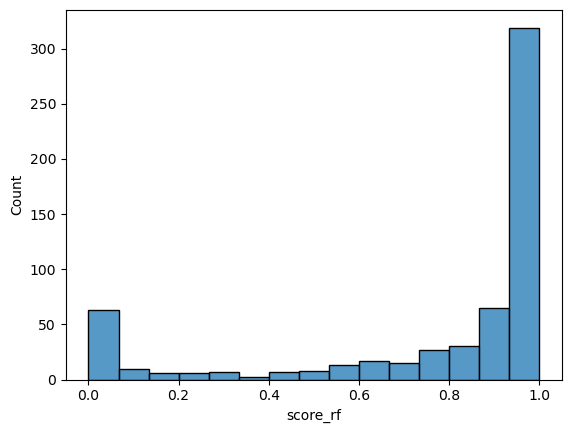

In [82]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [29]:
# Divide into tiles and compute cature al 0.02% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .02%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 2]['target']) / sum(Y_c['target']))

FRAUD CAPTURE .02%:
0.9681978798586572


In [30]:
# Table with totals by n-tile
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES_T

target,False,True
FRAUD_DECILE,,
1,32251,822
2,33066,7
3,33064,8
4,33071,2
5,33071,1
...,...,...
996,33072,0
997,33073,0
998,33072,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

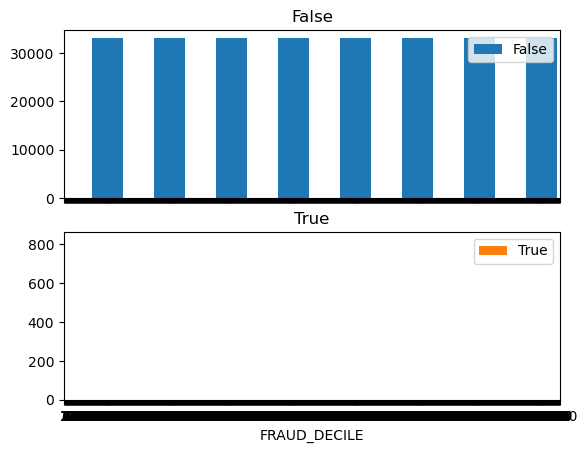

In [31]:
# Plot class by n-tile
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

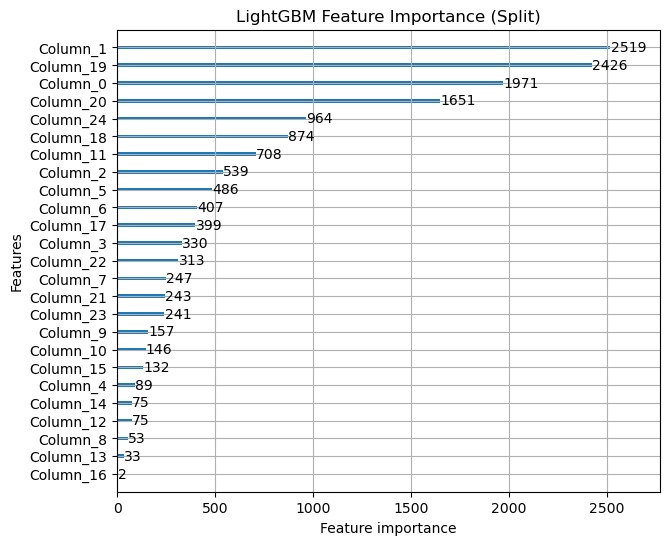

In [32]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

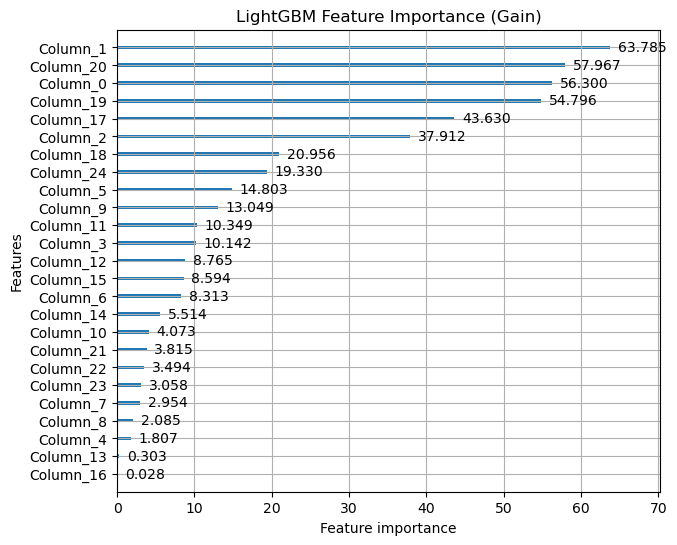

In [33]:
# Plot feature importance using Gain
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

## Save train model and buckets to score rest of transactions

In [36]:
# Run when it has to save new model
if save_model == 1: 
    import joblib
    joblib.dump(lgb_classifier, 'ModeloBiteRetrain.pkl')
    with open("./ModeloBiteRetrain.txt", "w") as output:
        output.write(str(var_input))

In [35]:
# Save thresholds to recode score
if save_model == 1: 
    pd.options.display.float_format = "{:,.20f}".format
    Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
    Buckets = Buckets.reset_index()
    Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
    Buckets.to_csv ('./BucketsModeloBiteRetrain.csv')

In [93]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinal_sin_rtcImp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## Evaluate model on test data ##

In [37]:
#Get thresold for .01% of data with highest score
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

In [39]:
# Load new data to test model
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
tes = pd.read_parquet(f"s3://{s3_url}/TargetTodosRetrain/Test/Test.parquet")

In [40]:
# Variable list for input
X = tes[var_input]
Y = tes['target'] 
testeo = tes

In [41]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [42]:
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  2489865
Dataset Shape:  (2489865, 118)


In [43]:
# Target distrinution for test data
testeo['target'].value_counts(dropna=False)

target
False    2489843
True          22
Name: count, dtype: int64

In [44]:
# Variables of model
X_TESTEO = tes[var_input]

# Target column for testing results 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Predict test using trained model
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [45]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data
Y_TESTEO_c = Y_TESTEO.copy()

# Set prediction and puntuationsof model for positive labels
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf
Y_TESTEO_c['score_rf'] = score_rf

# Get classification
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte

In [46]:
# Confusion matriz for predefined thershold 
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,2489843,0
1,21,1


In [47]:
# Confusion matriz for selected thershold 
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,2487682,2161
1,12,10


In [104]:
# Divide into tiles and analize scores for test dataset
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .02%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 2]['target']) / sum(Y_TESTEO_c['target']))

FRAUD CAPTURE .04%:
0.7195121951219512


In [105]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [106]:
DECILES

target,False,True
FRAUD_DECILE,,
1,9657,98
2,9739,15
3,9749,5
4,9748,6
5,9746,8
...,...,...
996,9754,0
997,9754,0
998,9754,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

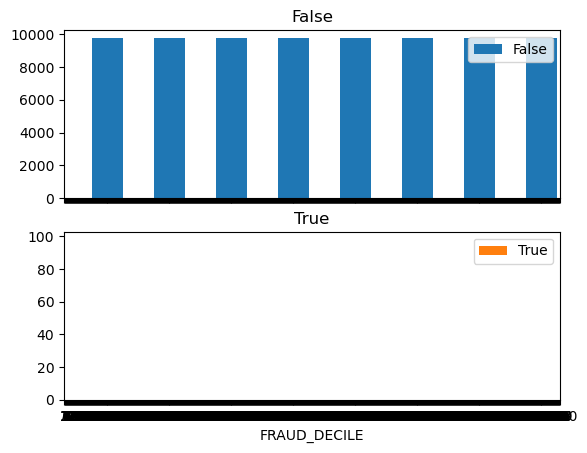

In [108]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)